In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy import constants
from scipy.linalg import lstsq
from matplotlib.animation import FuncAnimation
from Simbo import generate_levels, getrand, setzero, exchange, recdist, accum, plot_AB
plt.rcParams.update({'font.size': 8})

k_B = constants.value(u'Boltzmann constant')
h = constants.value(u'Planck constant')
c = constants.value(u'speed of light in vacuum')
nu = 500e2

<IPython.core.display.Javascript object>


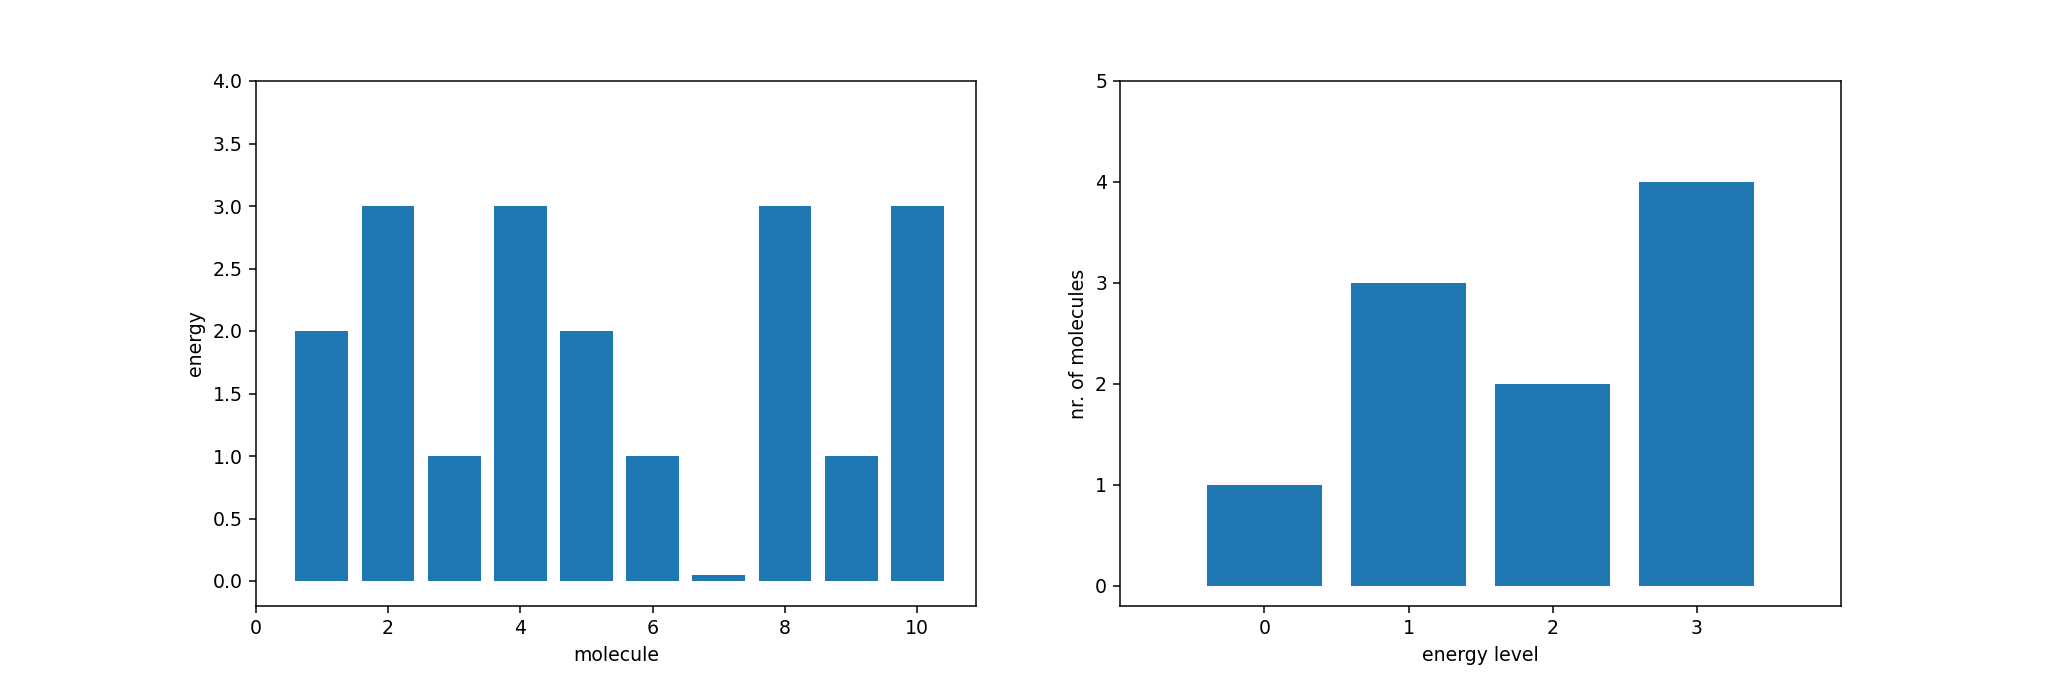

(-0.2, 5.0)

In [4]:
#plot levels and distribution just for fun

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
x = np.arange(1, nop+1, 1)

new_levels = np.copy(levels)
new_levels[new_levels==0] = 0.05

ax1.bar(x, new_levels)
xticks = np.arange(0, nop+1, 2)
ax1.set_xticks(xticks)
ax1.set_xlabel('molecule')
ax1.set_ylabel('energy')
ax1.set_ylim(-0.2, max(levels)+1)

maxlev = int(max(levels)+1)
distr = np.zeros(maxlev)

for i in range(0, nop):
    if levels[i] <= maxlev:
        distr[int(levels[i])] += 1
    else:
        print('error')

new_distr = np.copy(distr)
new_distr[new_distr==0] = 0.05
        
x = np.arange(0, len(new_distr), 1)
ax2.bar(x, new_distr)
ax2.set_xticks(x)
ax2.set_ylabel('nr. of molecules')
ax2.set_xlabel('energy level')
ax2.set_xlim(-1, max(x)+1)
ax2.set_ylim(-0.2, max(new_distr)+1)

<IPython.core.display.Javascript object>


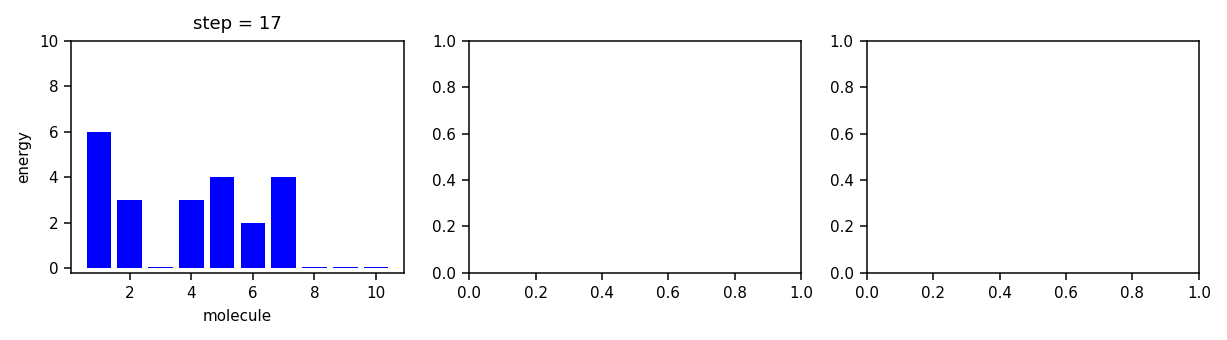

In [32]:
#run short simulation
%matplotlib notebook

nop = 10
istep = 0
nstot = 50*nop
nseqv = 20*nop

#initialize
if istep <= nseqv:
    
    #automatic generation of levels
    levels = generate_levels(2, nop)
    maxlev, idist, dist_sum, nstep = setzero(levels)
      
#prepare graphs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,2.5))
all_levels = []
all_distr = []

#run
while istep < nstot:
    
    bef = istep
    
    #get random molecules
    ifrom, ito = getrand(nop)
    
    #exchange and update max levels
    levels, maxlev, idist, dist_sum, istep = exchange(ifrom, ito, nop, levels, idist, dist_sum, istep)
    
    if istep > bef:
        
        #calculate distribution over energy levels
        distr, all_levels = recdist(nop, levels, maxlev, all_levels)
    
    #calculate accumulated distribution
    if istep > nseqv:
        idist, dist_sum = accum(maxlev, idist, distr, dist_sum, nstep)  
        nstep+=1
        
#animate plot data
def animation_frame(i):
    ax1.cla()
    
    labels = np.arange(1, nop+1, 1)
    trimmed_dist = all_levels[i]
    
    xticks = np.arange(0, nop+1, 2)
    ax1.set_xticks(xticks)
    ax1.set_xlabel('molecule')
    ax1.set_ylabel('energy')
    ax1.set_ylim(-0.2, nop)
    ax1.bar(x=labels, height=trimmed_dist, color='b')
    ax1.set_title(f'step = {i}')
    plt.tight_layout()

frames_no = len(all_levels)
animation = FuncAnimation(fig, animation_frame, frames=frames_no, interval=750)

In [5]:
#probability distribution
prdist = np.zeros(len(dist_sum))
lnprdist = np.zeros(len(dist_sum))

for i in range(len(dist_sum)):
    prdist[i] = dist_sum[i]/nop
    if prdist[i] != 0:
        lnprdist[i] = np.log(prdist[i])
    else:
        lnprdist[i] = 0
    
y = lnprdist[lnprdist != 0]

#calculate average energy
U = 0

for j in range(0, maxlev):
    U+=j*distr[j]
    
print('Average energy: %.4fe-21 J'%((U/nop)*h*c*nu*1e21))

Average energy: 12.9119e-21 J


1.5291 red.un. 1099.9885 K
Average energy: 10.7583e-21 J


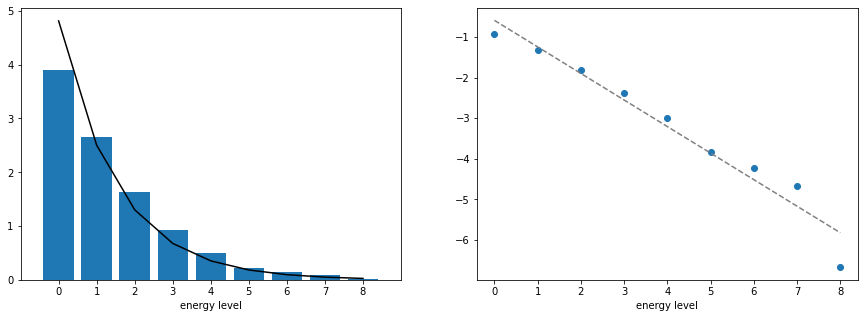

In [6]:
#least square fit to get temperature

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

x = np.arange(0, len(y))
M = x[:, np.newaxis]**[0, 1]
p, res, rnk, s = lstsq(M, y)
yy = p[0] + p[1]*x
temp = -1/p[1]
realtemp = temp*((h*c*nu)/k_B)
exp = (h*c*nu*1e23)/(k_B*1e23)

x1 = np.arange(0, len(dist_sum))
ax1.bar(x1, dist_sum)
ax1.set_xticks(x1)
ax1.set_xlabel('energy level')
ax1.set_xlim(-1, max(x1)+1)
q = np.sum(np.exp(-(x1)/temp))
bd = nop*(np.exp(-(x1)/temp)/q)
ax1.plot(x1, bd, color='k')

ax2.scatter(x, y)
ax2.set_xticks(x)
ax2.set_xlabel('energy level')
ax2.plot(x, yy, '--', color='gray')

print('%.4f red.un.' %(temp), '%.4f K' %(temp*((h*c*nu)/k_B)))
print('Average energy: %.4fe-21 J'%((h*c*nu)/(np.exp(exp*(1/realtemp))-1)*1e21))

In [50]:
#calculate Boltzmann entropy

num = np.math.factorial(nop)
denom = 1

for i in distr:
    denom*=np.math.factorial(i)
    
W = num/denom
print('Statistical weight: %.1f' %(W))

S_w = k_B * np.log(W)
print('Boltzmann entropy: %.4fe-21 J/K' %(S_w*1e21))

Statistical weight: 75600.0
Boltzmann entropy: 0.1551e-21 J/K


In [51]:
#calculate entropy for average distribution

num = nop*np.log(nop)-nop #Stirling approximation
denom = 0

for i in dist_sum:
    if i != 0:
        denom+=(i*np.log(i)-i) #Stirling approximation
    
lnW=num-denom
print('Statistical weight: %.1f' %(np.exp(lnW)))

S_a = k_B * lnW
print('Average entropy: %.4fe-21 J/K' %(S_a*1e21))

Statistical weight: 242749671.9
Average entropy: 0.2666e-21 J/K
